### importing libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### data loading

In [3]:
df=pd.read_csv('combined_social_data_features.csv')

In [4]:
df.head(5)

,account_name,caption,comment_count,share_count,like_count,platform,hashtags,mentions,engagement_score,caption_length,word_count,sentiment_score,hashtag_count,mention_count
0,McDonald's,SWIPE TO SEE WHAT PRIZES ARE LEFT!!! IT’S NOT ...,128,31,299,Facebook,NaN,NaN,458,149,29,0.303516,0,0
1,McDonald's,6 episodes\n25 Grimace family members\n1 wacky...,413,59,462,Facebook,NaN,NaN,934,92,16,0.425000,0,0
2,McDonald's,my dms can rest now,612,33,393,Facebook,NaN,NaN,1038,19,5,0.000000,0,0
3,McDonald's,MONOPOLY IS BACK AT McD’S! AVAILABLE ALL DAY! ...,1781,792,2677,Facebook,NaN,NaN,5250,122,23,0.195833,0,0
4,McDonald's,it all started with a McDonald's napkin... a s...,271,71,363,Facebook,NaN,NaN,705,117,19,0.000000,0,0


### checking null values

In [5]:
df.isnull().sum()

account_name           0
caption                0
comment_count          0
share_count            0
like_count             0
platform               0
hashtags            1044
mentions            1044
engagement_score       0
caption_length         0
word_count             0
sentiment_score        0
hashtag_count          0
mention_count          0
dtype: int64

### heatmap
**we are going to plot Correlation heatmap to visualiza Correlation between columns**

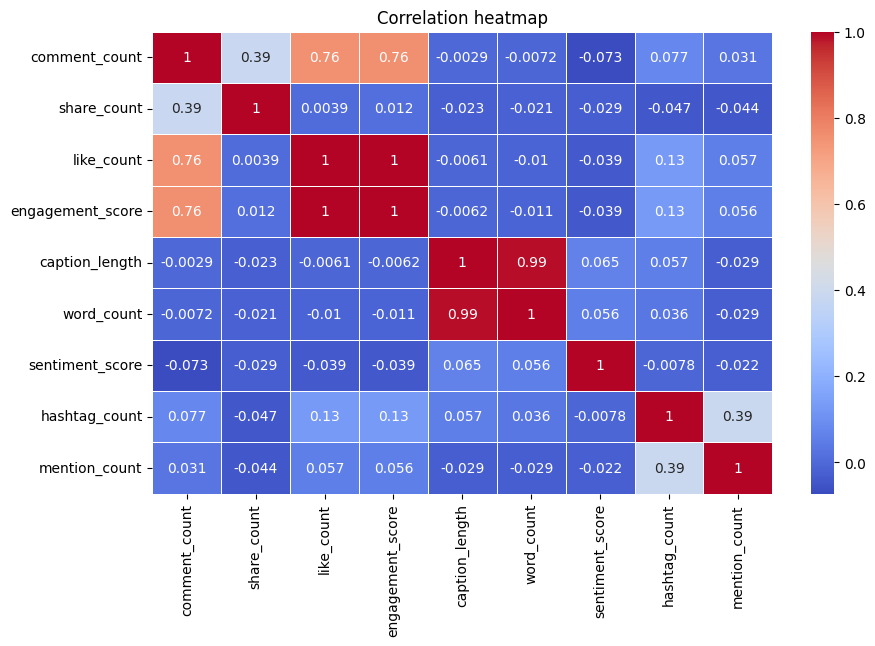

In [7]:
num_df = df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

### cleaning caption
**now we are going to work on caption column**

In [8]:
import re
from nltk.corpus import stopwords

def clean_caption(text):
    stop = set(stopwords.words('english'))
    
    text = str(text).lower()                                # lowercase
    text = re.sub(r'http\S+|www\S+', '', text)              # remove URLs
    text = re.sub(r'\n', ' ', text)                         # remove newlines
    text = re.sub(r'[^\w\s]', '', text)                     # remove punctuation
    text = re.sub(r'\d+', '', text)                         # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()                # remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop])  # remove stopwords
    
    return text

# Apply function to your column
df['caption'] = df['caption'].apply(clean_caption)


### dropping cols

In [9]:
df = df.drop(['share_count', 'mentions', 'hashtags','hashtag_count','mention_count'], axis=1)

### calculating engagement score

In [10]:
df["engagement_score"]=df["like_count"]+df["comment_count"]

### top brands by engagement score

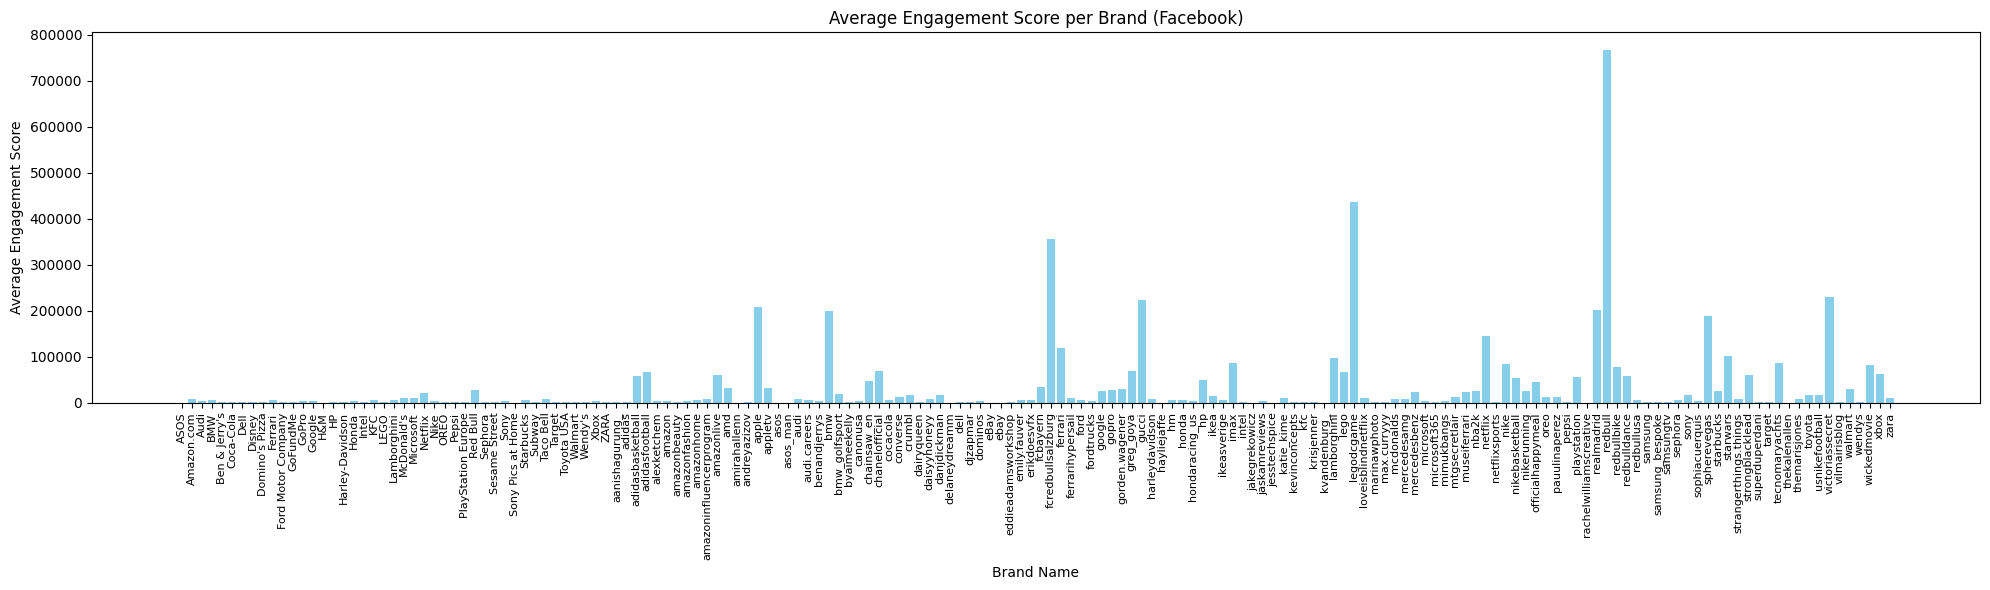

In [11]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# Plot
plt.figure(figsize=(20,6))  # wider figure for more labels
plt.bar(brand_engagement['account_name'], brand_engagement['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Average Engagement Score per Brand (Facebook)')
plt.xticks(rotation=90, fontsize=8)  # rotate and shrink font
plt.tight_layout()
plt.show()

## top 20 brands

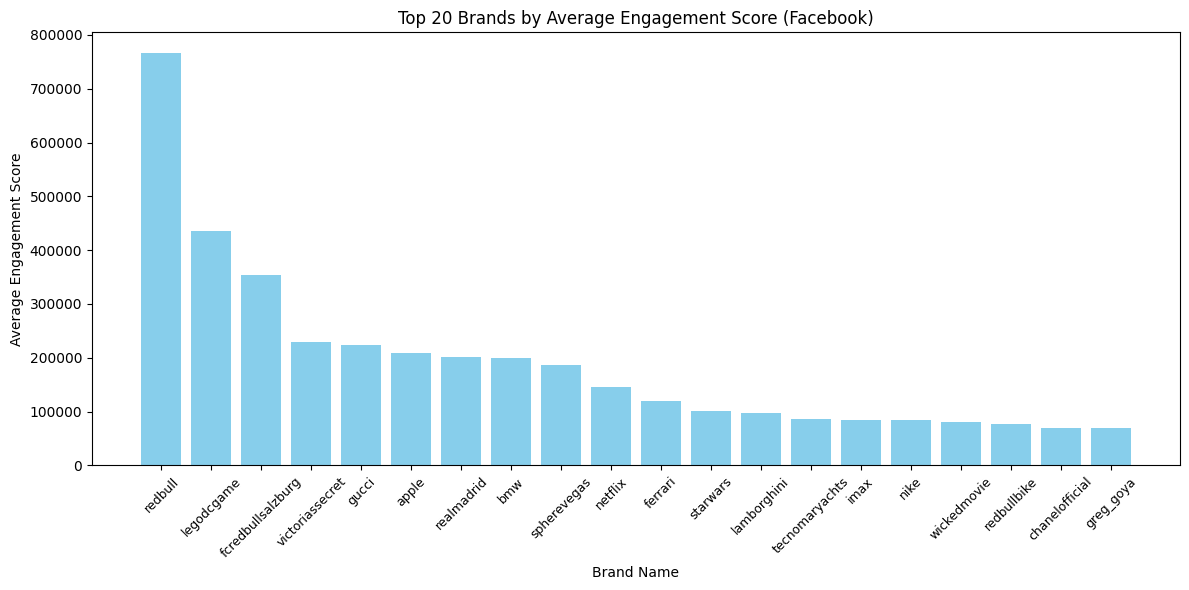

In [12]:
brand_engagement = df.groupby('account_name')['engagement_score'].mean().reset_index()

# sort and select top 20
top20 = brand_engagement.sort_values(by='engagement_score', ascending=False).head(20)

# Plot
plt.figure(figsize=(12,6))
plt.bar(top20['account_name'], top20['engagement_score'], color='skyblue')

plt.xlabel('Brand Name')
plt.ylabel('Average Engagement Score')
plt.title('Top 20 Brands by Average Engagement Score (Facebook)')
plt.xticks(rotation=45, fontsize=9)
plt.tight_layout()
plt.show()


## dealing with  outliers
####  **we noticed that we have outlyers in columns. now we will chk is iqr triming or iqr capping working good on outlyers. later we will use it for like and comment also**

### 1. engagement score

In [13]:
lower_power=df['engagement_score'].quantile(0.25)
uper_power=df['engagement_score'].quantile(0.75)
iqr=uper_power-lower_power

In [14]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [15]:
#using iqr capping method
new_df_cap=df.copy()
new_df_cap['engagement_score']=np.where(
    new_df_cap['engagement_score']>upper_limit,
    upper_limit,
    np.where(
        new_df_cap['engagement_score']<lower_limit,
        lower_limit,
        new_df_cap['engagement_score']
    )

)


## visualization 

#### box plot for engagement score after & before imputing outliers

C:\Users\Asad\AppData\Local\Temp\ipykernel_15632\196828629.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['engagement_score'])
C:\Users\Asad\AppData\Local\Temp\ipykernel_15632\196828629.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df_cap['engagement_score'])


{'whiskers': [<matplotlib.lines.Line2D at 0x1f839e72350>,
 'caps': [<matplotlib.lines.Line2D at 0x1f839e725d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f839e72210>],
 'medians': [<matplotlib.lines.Line2D at 0x1f839e72850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f839e72990>],
 'means': []}

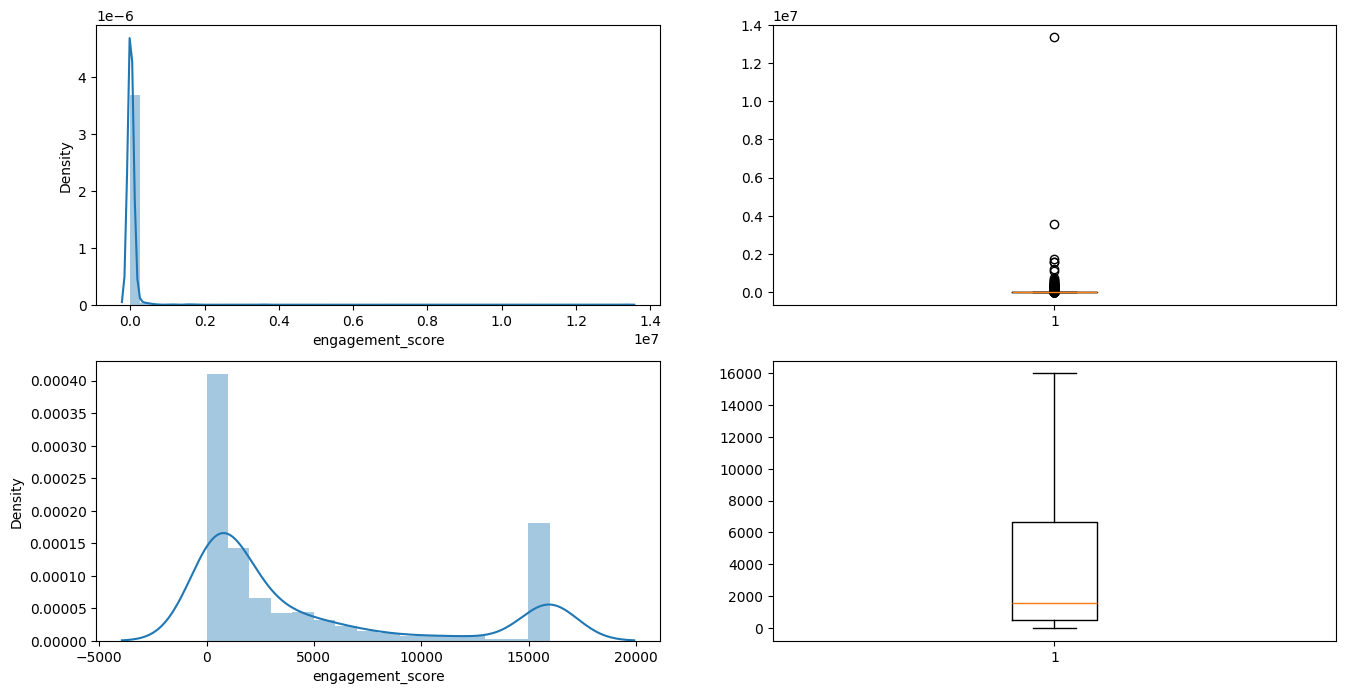

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['engagement_score'])
plt.subplot(2,2,2)
plt.boxplot(df['engagement_score'])
plt.subplot(2,2,3)
sns.distplot(new_df_cap['engagement_score'])
plt.subplot(2,2,4)
plt.boxplot(new_df_cap['engagement_score'])

### 2. like count

In [18]:
lower_power=new_df_cap['like_count'].quantile(0.25)
uper_power=new_df_cap['like_count'].quantile(0.75)
iqr=uper_power-lower_power


In [19]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [20]:
#using iqr capping method
newDf=new_df_cap.copy()
newDf['like_count']=np.where(
    newDf['like_count']>upper_limit,
    upper_limit,
    np.where(
        newDf['like_count']<lower_limit,
        lower_limit,
        newDf['like_count']
    )

)


### visualizing like-count after and before outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1f837b5e850>,
 'caps': [<matplotlib.lines.Line2D at 0x1f837b5ead0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f837b5e710>],
 'medians': [<matplotlib.lines.Line2D at 0x1f837b5ed50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f837b5ee90>],
 'means': []}

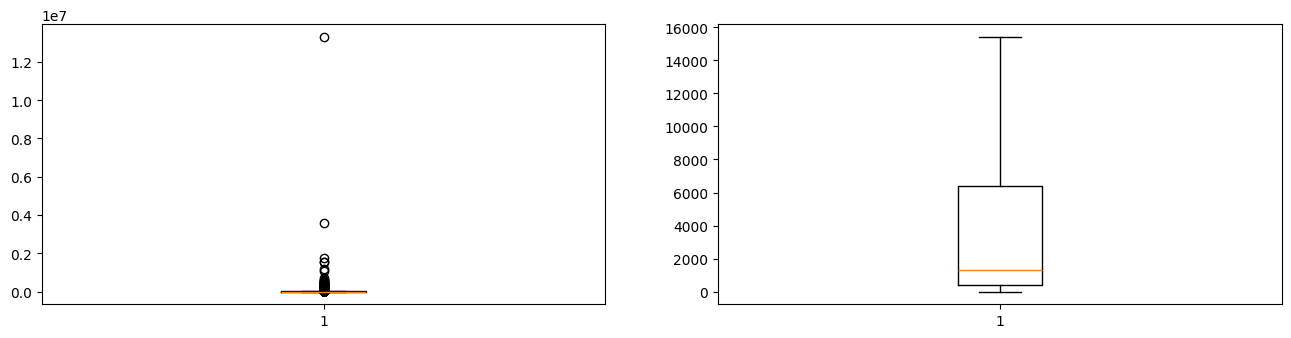

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['like_count'])
plt.subplot(2,2,2)
plt.boxplot(newDf['like_count'])

### 3. for comment count

In [22]:
lower_power=newDf['comment_count'].quantile(0.25)
uper_power=newDf['comment_count'].quantile(0.75)
iqr=uper_power-lower_power

In [23]:
upper_limit=uper_power+1.5*iqr
lower_limit=lower_power-1.5*iqr

In [24]:
#using iqr capping method
Df=newDf.copy()
Df['comment_count']=np.where(
    Df['comment_count']>upper_limit,
    upper_limit,
    np.where(
     Df['comment_count']<lower_limit,
        lower_limit,
        Df['comment_count']
    )

)

### visualizing comment_count after and before imputing outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1f83b492350>,
 'caps': [<matplotlib.lines.Line2D at 0x1f83b4925d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f83b492210>],
 'medians': [<matplotlib.lines.Line2D at 0x1f83b492850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f83b492990>],
 'means': []}

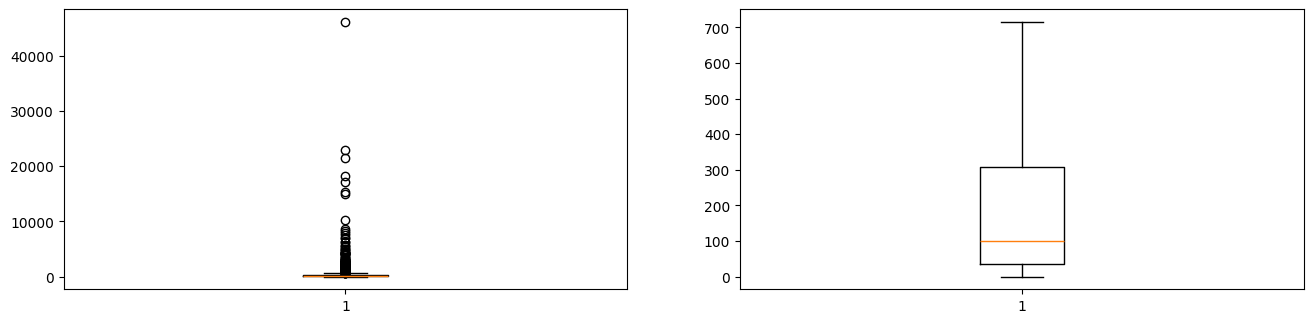

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.boxplot(df['comment_count'])
plt.subplot(2,2,2)
plt.boxplot(Df['comment_count'])

## heatmap after outliers

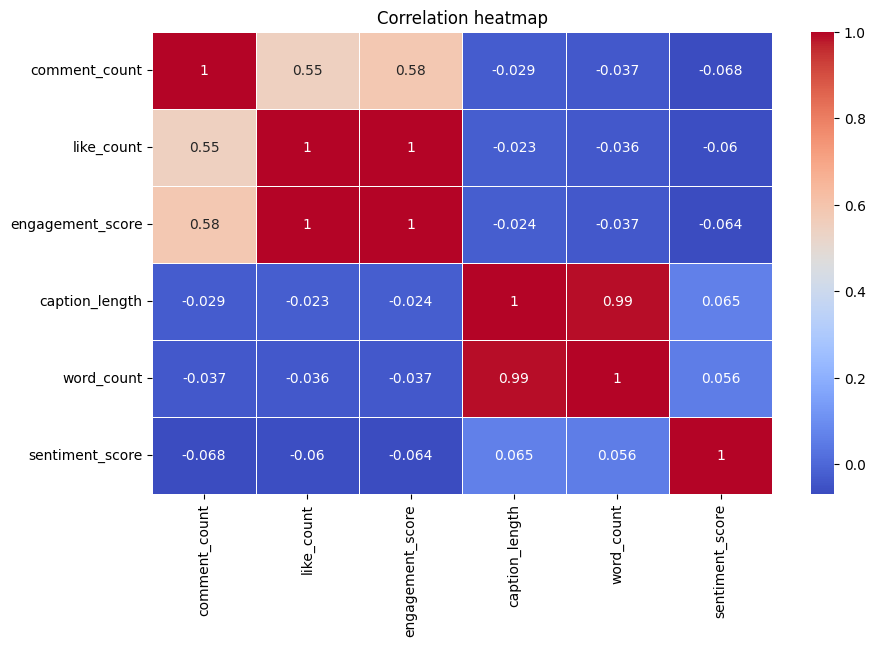

In [26]:
num_df = Df.select_dtypes(include = ["int64", "float64"])
plt.figure(figsize =(10,6))
sns.heatmap(num_df.corr(), annot = True, cmap= "coolwarm", linewidth = 0.5)
plt.title("Correlation heatmap")
plt.show()

## Model Training

#### train test split

In [27]:
X=Df.drop(['engagement_score'],axis=1)
Y=Df['engagement_score']

In [28]:
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=42)
X_train

,account_name,caption,comment_count,like_count,platform,caption_length,word_count,sentiment_score
1733,honda,iconic honda prelude making return visit link ...,715.0,15419.0,Instagram,82,16,0.500000
1556,xbox,take favorite games wherever rog xbox ally rog...,715.0,15419.0,Instagram,111,21,0.500000
1641,gopro,rescuing baby shark goproawards recipient vinc...,112.0,15419.0,Instagram,315,49,0.250000
175,Wendy's,little allways went wendys school nd streeet s...,715.0,2521.0,Facebook,172,36,-0.138393
1102,target,laurenwolfe takes us behind scenes woolrich ta...,4.0,460.0,Instagram,189,29,-0.142857
...,...,...,...,...,...,...,...,...
1130,walmart,heard deals coming oct right hearing right,40.0,372.0,Instagram,74,13,0.285714
1294,starbucks,favorite drink add protein,238.0,4297.0,Instagram,37,6,0.500000
860,Amazon.com,eyes sameday delivery amazondelivery skeletons...,715.0,12985.0,Facebook,76,9,0.000000
1459,apple,lets dance commissioned apple new iphone pro b...,488.0,15419.0,Instagram,196,29,0.136364


#### now we are going to use columntransformer to handle all columns. under the ColumnTransformer we will use vectorization and one hotencoder for our non numeric columns

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        # 1️⃣ Apply TF-IDF on caption
        ('tfidf', TfidfVectorizer(stop_words='english'), 'caption'),

        # 2️⃣ One-Hot Encode account_name & platform
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'),
         ['account_name', 'platform']),

        # 3️⃣ Pass numeric columns as they are
        ('num', 'passthrough',
         ['comment_count', 'like_count', 'caption_length', 'word_count', 'sentiment_score'])
    ]
)

##### making a pipeline for columntransformer and algorithm fiting

In [30]:
model = Pipeline(steps=[
    ('preprocess', preprocessor),   # your ColumnTransformer
    ('rf', RandomForestRegressor(random_state=42))
])

### model training

In [31]:
model.fit(X_train, Y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf', ...), ('onehot', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
y_pred = model.predict(X_test)

c:\Users\Asad\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [33]:
y_pred

array([1.59751250e+04, 2.26350000e+02, 1.59751250e+04, 5.63800000e+02,
       6.19005000e+03, 1.35159000e+03, 5.22733000e+03, 2.83705000e+03,
       4.25330000e+02, 1.59713438e+04, 9.58400000e+01, 6.70763000e+03,
       5.22717000e+03, 1.59751250e+04, 3.29708000e+03, 9.56500000e+01,
       1.27800000e+02, 1.83756000e+03, 3.54100000e+01, 9.45950000e+02,
       6.26080000e+02, 1.59751250e+04, 8.81230000e+02, 1.85252000e+03,
       1.59551100e+04, 1.50653000e+03, 8.83160000e+02, 1.74330000e+02,
       5.08794000e+03, 2.44637000e+03, 1.59751250e+04, 2.80170000e+02,
       2.14688000e+03, 1.45287000e+03, 1.68532000e+03, 8.53510000e+02,
       5.82870000e+02, 1.59751250e+04, 2.36052000e+03, 6.86900000e+02,
       1.59751250e+04, 7.86510000e+02, 3.57455000e+03, 4.20716000e+03,
       6.44969000e+03, 5.72407000e+03, 4.45890000e+02, 8.59230000e+02,
       1.49960000e+02, 1.00065800e+04, 6.48450000e+02, 9.97427000e+03,
       4.82670000e+02, 3.86616000e+03, 4.66910000e+02, 1.39895000e+03,
      

### model evaluation

In [34]:
print("MSE:", mean_squared_error(Y_test, y_pred))
print("R2 Score:", r2_score(Y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(Y_test, y_pred)))
print("MAE:", mean_absolute_error(Y_test, y_pred))


MSE: 42986.902523328994
R2 Score: 0.9985938005754236
RMSE: 207.3328303075251
MAE: 60.00702430555555


### downloading model

In [ ]:
import pickle
print("Saving the model...")
with open('ads_predictor.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("Model saved successfully!")

Saving the model...
Model saved successfully!
